This notebook plots the private network latency contribution as a ratio of hop1 to hop2 latencies.
- - - 

In [101]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [102]:
import warnings
warnings.filterwarnings('ignore')

In [103]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [104]:
import sqlite3
import pandas as pd

In [105]:
DB_LOCATION = 'lastmile.db'

In [106]:
RA_PROBE = 'ra_probe'
RA_ONE_OFF_EXTENSIONS = 'ra_one_off_extensions'
RA_LATENCIES_AGG = 'ra_latencies_agg'
RA_LATENCIES_LAST_HOP_AGG = 'ra_latencies_last_hop_agg'

In [107]:
SK_ONE_OFF_EXTENSIONS = 'sk_one_off_extensions'
SK_LATENCIES_AGG = 'sk_latencies_agg'
SK_LATENCIES_LAST_HOP_AGG = 'sk_latencies_last_hop_agg'
SK_ASN = 'sk_asn'
METADATA_SNAPSHOT = 'metadata_snapshot'
METADATA_SNAPSHOT_EXTENSIONS = 'metadata_snapshot_extensions'

In [108]:
con = sqlite3.connect(DB_LOCATION)

In [109]:
query_ra = '''SELECT      agg.probeid
                        , agg.timestamp
                        , agg.h1_median || ';' || agg.h2_median || ';' || lh.last_hop_median as h1h2lh

               FROM   %s                             as  agg
                    , %s                             as  hardware
                    , %s                             as  ext
                    , %s                             as  lh

               WHERE     agg.probeid                  =  hardware.probeid
               AND       agg.probeid                  =  ext.probeid
               AND       agg.probeid                  =  lh.probeid
               AND       agg.timestamp                =  lh.timestamp               

               AND       hardware.hardware_version    =  'v3'
               AND       ext.if_residential           =  1
               
            '''%(  RA_LATENCIES_AGG
                 , RA_PROBE
                 , RA_ONE_OFF_EXTENSIONS
                 , RA_LATENCIES_LAST_HOP_AGG
                )

df_ra = pd.read_sql(query_ra, con)

In [110]:
df_ra.count()

probeid      133533
timestamp    133533
h1h2lh       129045
dtype: int64

In [111]:
df_ra.head()

,probeid,timestamp,h1h2lh
0,10006,1406548034,0.429;20.49;64.929
1,10006,1406562432,0.431;17.7;64.194
2,10006,1406576835,0.438;17.776;64.473
3,10006,1406591230,0.478;17.577;64.46
4,10006,1406605631,0.422;17.526;64.059


In [112]:
query_sk = ''' SELECT     agg.probeid
                        , agg.timestamp
                        , s.asn       
                        , s.asn_holder_name
                        , meta.product                        
                        , agg.h1_avg || ';' || agg.h2_avg || ';' || lh.last_hop_avg as h1h2lh

                                                                                     
               FROM       %s                            as   agg
                        , %s                            as   api               
                        , %s                            as   ext
                        , %s                            as   s
                        , %s                            as   meta
                        , %s                            as   lh
                        
                        

               WHERE      agg.probeid                    =    ext.probeid
               AND        agg.probeid                    =    api.probeid
               AND        agg.probeid                    =    meta.id               
               AND        agg.probeid                    =    lh.probeid
               AND        agg.timestamp                  =    lh.timestamp
               AND        api.asn                        =    s.asn               
               
               AND        ext.if_residential             =    1
               AND        agg.h1_avg                     <>   0
               AND        agg.h2_avg                     <>   0
               AND        lh.last_hop_avg                <>   0               
               
           '''%(   SK_LATENCIES_AGG
                 , METADATA_SNAPSHOT_EXTENSIONS                
                 , SK_ONE_OFF_EXTENSIONS
                 , SK_ASN        
                 , METADATA_SNAPSHOT                
                 , SK_LATENCIES_LAST_HOP_AGG
               )

df_sk = pd.read_sql(query_sk, con)

In [113]:
df_sk.count()

probeid            435813
timestamp          435813
asn                435813
asn_holder_name    435813
product            435813
h1h2lh             435813
dtype: int64

In [114]:
df_sk.head()

,probeid,timestamp,asn,asn_holder_name,product,h1h2lh
0,14905,2014-07-28 00:36:14,2856,"BT-UK-AS BT Public Internet Service,GB",40,0.794;7.423;22.676
1,14905,2014-07-28 00:36:18,2856,"BT-UK-AS BT Public Internet Service,GB",40,0.787;7.41;100.878
2,14905,2014-07-28 12:36:52,2856,"BT-UK-AS BT Public Internet Service,GB",40,0.786;7.687;24.642
3,14905,2014-07-28 12:36:56,2856,"BT-UK-AS BT Public Internet Service,GB",40,0.808;7.539;98.557
4,14905,2014-07-28 16:36:10,2856,"BT-UK-AS BT Public Internet Service,GB",40,0.813;7.576;19.646


In [115]:
df_ra = df_ra.dropna()

In [116]:
df_sk = df_sk.dropna()

In [117]:
df_sk.count()

probeid            435813
timestamp          435813
asn                435813
asn_holder_name    435813
product            435813
h1h2lh             435813
dtype: int64

In [118]:
df_ra.count()

probeid      129045
timestamp    129045
h1h2lh       129045
dtype: int64

In [119]:
def calculate_private_contribution(h1h2lh):
    try: h1,h2,lh = h1h2lh.split(';')
    except Exception as e: print(e, type(e), h1h2); return None
    
    try: contribution = float(h1) / float(h2) * 100
    except Exception as e: print(e, type(e), h1, h2); return None
    
    return contribution

In [120]:
def calculate_contribution(h1h2lh):
    try: h1,h2,lh = h1h2lh.split(';')
    except Exception as e: print(e, type(e), h1h2); return None
    
    try: contribution = float(h2) - float(h1) / float(lh) * 100
    except Exception as e: print(e, type(e), h1, h2); return None
    
    return contribution

In [121]:
df_ra['lm_contribution'] = df_ra['h1h2lh'].apply(calculate_contribution)
df_sk['lm_contribution'] = df_sk['h1h2lh'].apply(calculate_contribution)

df_ra['pv_contribution'] = df_ra['h1h2lh'].apply(calculate_private_contribution)
df_sk['pv_contribution'] = df_sk['h1h2lh'].apply(calculate_private_contribution)

In [122]:
df_ra_groupby = df_ra.groupby('probeid')
df_ra_agg = df_ra_groupby['lm_contribution', 'pv_contribution'].agg(['median'])
df_ra_merged = pd.merge(df_ra, df_ra_agg, left_on='probeid', right_index=True)

del df_ra_merged['timestamp']
del df_ra_merged['h1h2lh']
del df_ra_merged['lm_contribution']
del df_ra_merged['pv_contribution']

df_ra_merged = df_ra_merged.drop_duplicates()
df_ra_merged.rename(columns={'median': 'lm_contribution'}, inplace=True)

In [123]:
df_sk_groupby = df_sk.groupby('probeid')
df_sk_agg = df_sk_groupby['lm_contribution', 'pv_contribution'].agg(['median'])
df_sk_merged = pd.merge(df_sk, df_sk_agg, left_on='probeid', right_index=True)

del df_sk_merged['timestamp']
del df_sk_merged['h1h2lh']
del df_sk_merged['lm_contribution']
del df_sk_merged['pv_contribution']

df_sk_merged = df_sk_merged.drop_duplicates()
df_sk_merged.rename(columns={'median': 'lm_contribution'}, inplace=True)

In [124]:
df_ra_merged.count()

probeid                      691
(lm_contribution, median)    691
(pv_contribution, median)    691
dtype: int64

In [125]:
df_sk_merged.count()

probeid                      1245
asn                          1245
asn_holder_name              1245
product                      1245
(lm_contribution, median)    1245
(pv_contribution, median)    1245
dtype: int64

In [126]:
df_sk_merged.columns = ['probeid', 'asn', 'asn_holder_name', 'product', 'lm_contribution', 'pv_contribution']
df_ra_merged.columns = ['probeid', 'lm_contribution', 'pv_contribution']

In [127]:
df_ra_merged[df_ra_merged.pv_contribution >= 100].count()

probeid            3
lm_contribution    3
pv_contribution    3
dtype: int64

In [128]:
df_sk_merged[df_sk_merged.pv_contribution >= 100].count()

probeid            124
asn                124
asn_holder_name    124
product            124
lm_contribution    124
pv_contribution    124
dtype: int64

### remove probes where hop1 > 100% of hop2

In [129]:
df_sk_merged = df_sk_merged[df_sk_merged.pv_contribution < 100]
df_ra_merged = df_ra_merged[df_ra_merged.pv_contribution < 100]

In [130]:
import Cdf
import Pmf
ra_sample = df_ra_merged['lm_contribution'].values
sk_sample = df_sk_merged['lm_contribution'].values
ra_c = Cdf.MakeCdfFromList(ra_sample)
sk_c = Cdf.MakeCdfFromList(sk_sample)

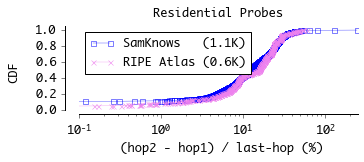

In [131]:
# ---- plt.style.use('ggplot')
fig = plt.figure(figsize=(5,1.5))
plt.rcParams['font.size'] = 12
yticks = np.arange(0,1.1,0.2)
ax = plt.gca()

ax.plot (   sk_c.xs
          , sk_c.ps
          , marker='s'
          , linewidth=0.3
          , markersize=5
          , fillstyle='none'
          , color='Blue'
         )

ax.plot (  ra_c.xs
          , ra_c.ps
          , marker='x'
          , linewidth=0.3
          , markersize=5
          , color='Violet'
         )

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax.yaxis.set_label_coords(-0.21, 0.45)
ax = fig.axes[0]
ax.grid(False)
ax.set_yticks(yticks)
ax.set_ylim([0,1.05])
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')
ax.set_xlabel(' (hop2 - hop1) / last-hop (%)', fontsize=12)
ax.set_ylabel('CDF', fontsize=12)
ax.legend(['SamKnows   (1.1K)', 'RIPE Atlas (0.6K)'], fontsize=12, bbox_to_anchor=(0.9, -0.55))
ax.legend(['SamKnows   (1.1K)', 'RIPE Atlas (0.6K)'], fontsize=12, loc='best')
plt.title('Residential Probes', fontsize=12, y=1.05)
plt.savefig('ripeatlas-samknows-lm-contribution.pdf', format='pdf', bbox_inches='tight')

In [132]:
with open('ra-lm-contribution.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(ra_c.xs, ra_c.ps): f.write('%.2f; %.2f\n'%(x,y))
        
with open('sk-lm-contribution.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(sk_c.xs, sk_c.ps): f.write('%.2f; %.2f\n'%(x,y))        